# Code
...
# Imports

In [32]:
import pandas as pd
from pathlib import Path
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Optional, Tuple, Union
import seaborn as sns
import matplotlib.pyplot as plt

# User Configuration

In [61]:
SAVE_FIGS = True  # Save figures

REAL_FILE = "20250301_data_20250510_122405_final_100_train.csv"
SYNTH_FILE = "20250301_data_20250510_122405_final_100_synth.csv"
HOLDOUT_FILE = "20250301_data_20250510_122405_final_100_holdout.csv"

DATA_DIR = Path("../../data")
OUTPUT_DIR_FIG = Path("figures")
OUTPUT_DIR_FIG.mkdir(parents=True, exist_ok=True)  # ensure output folder exists

# Set my design
sns.set_theme(
    style="white",
    context="paper",
    palette="colorblind",
    rc={
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
        "font.size": 7,
        "axes.titlesize": 7,
        "axes.labelsize": 7,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "legend.fontsize": 7
    }
)

# Utility Functions

## Load Data & Assign Correct Datatypes

In [34]:
def convert_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Konvertiert bestimmte Spalten des DataFrames in die gewünschten Datentypen:
     - definierte Spalten als category
     - definierte Spalten als pandas Nullable Integer (Int64)
     - consciousness_level und news_score als geordnete Categoricals
    """
    df = df.copy()  # Änderungen nicht am Original vornehmen

    # 1) Kategorische Spalten
    cat_cols = ['gender', 'ethnicity', 'chief_complaint', 'icd_block']
    for col in cat_cols:
        df[col] = df[col].astype('category')

    # 2) Integer-Spalten mit Nullable Integer dtype
    int_cols = ['age', 'systolic_bp', 'diastolic_bp',
                'heart_rate', 'respiratory_rate', 'oxygen_saturation']
    for col in int_cols:
        df[col] = df[col].astype('Int64')

    # 3) Geordnete Categoricals
    df['consciousness_level'] = pd.Categorical(
        df['consciousness_level'],
        categories=['A', 'C', 'V', 'P', 'U'],
        ordered=True
    )
    df['news_score'] = pd.Categorical(
        df['news_score'],
        categories=list(range(19)),
        ordered=True
    )

    return df

def load_data(
    real_filename: Union[str, Path],
    synth_filename: Optional[Union[str, Path]] = None,
    holdout_filename: Optional[Union[str, Path]] = None,
    data_dir: Path = DATA_DIR
) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.DataFrame]]:
    """
    Lädt die realen, synthetischen und optionalen Holdout-CSV-Dateien
    aus data_dir und wandelt sie über convert_dtypes um.

    Returns:
        df_real: pd.DataFrame
        df_synth: Optional[pd.DataFrame]
        df_holdout: Optional[pd.DataFrame]
    """
    def _read_and_convert(fn: Union[str, Path]) -> pd.DataFrame:
        return (
            pd.read_csv(data_dir / fn, low_memory=False)
              .pipe(convert_dtypes)
        )

    df_real    = _read_and_convert(real_filename)
    df_synth   = _read_and_convert(synth_filename)   if synth_filename   else None
    df_holdout = _read_and_convert(holdout_filename) if holdout_filename else None

    return df_real, df_synth, df_holdout

## Countplots (Categorical Values)

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_metric_comparison(
    df_real: pd.DataFrame,
    df_synth: pd.DataFrame,
    metric_col: str,
    figsize: tuple = (6, 4),
    title: str = None,
    lower_bound: float = None,
    upper_bound: float = None,
    yticks_step: float = 10,
    top_k: int = None,
    horizontal: bool = False,
    label_rotation: int = 0,
    show_legend: bool = True
):
    # Prozentuale Häufigkeiten pro Quelle
    real_counts = df_real[metric_col].value_counts(normalize=True) * 100
    synth_counts = df_synth[metric_col].value_counts(normalize=True) * 100

    # Optional Top-k Kategorien auswählen
    if top_k is not None:
        total_counts = real_counts.add(synth_counts, fill_value=0)
        top_categories = total_counts.nlargest(top_k).index
        real_counts = real_counts.reindex(top_categories, fill_value=0)
        synth_counts = synth_counts.reindex(top_categories, fill_value=0)
        order = list(top_categories)
    else:
        # Gemeinsames Set aller Kategorien
        all_cats = real_counts.index.union(synth_counts.index)
        real_counts = real_counts.reindex(all_cats, fill_value=0)
        synth_counts = synth_counts.reindex(all_cats, fill_value=0)
        order = list(all_cats)

    # DataFrame zum Plotten
    plot_df = pd.DataFrame({
        'Real': real_counts,
        'Synthetic': synth_counts
    }, index=order)

    fig, ax = plt.subplots(figsize=figsize)
    width = 0.35  # Balkenbreite

    ind = np.arange(len(order))
    if horizontal:
        ax.barh(ind - width/2, plot_df['Real'], height=width, label='Real')
        ax.barh(ind + width/2, plot_df['Synthetic'], height=width, label='Synthetic')
        ax.set_yticks(ind)
        ax.set_yticklabels(order, rotation=label_rotation)
        if lower_bound is not None and upper_bound is not None:
            ax.set_xlim(lower_bound, upper_bound)
            ax.set_xticks(np.arange(lower_bound, upper_bound + yticks_step, yticks_step))
        ax.set_xlabel('Percent (%)')
    else:
        ax.bar(ind - width/2, plot_df['Real'], width=width, label='Real')
        ax.bar(ind + width/2, plot_df['Synthetic'], width=width, label='Synthetic')
        ax.set_xticks(ind)
        ax.set_xticklabels(order, rotation=label_rotation, ha='right' if label_rotation else 'center')
        if lower_bound is not None and upper_bound is not None:
            ax.set_ylim(lower_bound, upper_bound)
            ax.set_yticks(np.arange(lower_bound, upper_bound + yticks_step, yticks_step))
        ax.set_ylabel('Percent')

    # Styling, Titel, etc.
    ax.set_title(title or f"{metric_col}")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if show_legend:
        ax.legend()

    plt.tight_layout()

    # Prozent-Label für Top-k
    if top_k is not None:
        pct_real = plot_df['Real'].sum()
        pct_synth = plot_df['Synthetic'].sum()
        label_text = f"Cumulative %\nof Top {top_k}\nReal: {pct_real:.1f}%\nSynth: {pct_synth:.1f}%"
        # Label-Position je nach Plot-Orientierung
        if horizontal:
            ax.text(0.90, 0.90, label_text, transform=ax.transAxes,
                    ha='right', va='top',
                    fontsize=7,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
        else:
            ax.text(0.95, 0.95, label_text, transform=ax.transAxes,
                    ha='right', va='top',
                    fontsize=6,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    return fig


# Main Routine
## Daten Laden

In [36]:
df_real, df_synth, df_holdout = load_data(
    REAL_FILE,
    SYNTH_FILE,
    HOLDOUT_FILE,
    data_dir=DATA_DIR
)

## icu_admission_24h

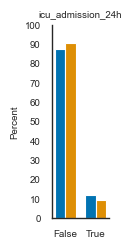

In [70]:
fig = plot_metric_comparison(
    df_real,
    df_synth,
    metric_col='icu_admission_24h',
    figsize=(1.2, 2.5),
    lower_bound = 0,
    upper_bound = 100,
    yticks_step = 10,
    show_legend = False
)
plt.show()
if SAVE_FIGS:
    fig.savefig(f"{OUTPUT_DIR_FIG}/icu_admission_24h.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.close(fig)

## gender

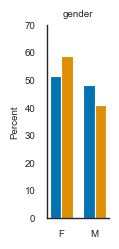

In [71]:
fig = plot_metric_comparison(
    df_real,
    df_synth,
    metric_col='gender',
    figsize=(1.2, 2.5),
    lower_bound = 0,
    upper_bound = 70,
    yticks_step = 10,
    show_legend = False
)
plt.show()
if SAVE_FIGS:
    fig.savefig(f"{OUTPUT_DIR_FIG}/gender.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.close(fig)

## ethnicity

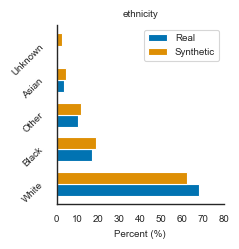

In [72]:
fig = plot_metric_comparison(
    df_real,
    df_synth,
    metric_col='ethnicity',
    figsize=(2.4, 2.5),
    lower_bound = 0,
    upper_bound = 80,
    yticks_step = 10,
    horizontal= True,
    label_rotation = 45,
    show_legend = True
)
plt.show()
if SAVE_FIGS:
    fig.savefig(f"{OUTPUT_DIR_FIG}/ethnicity.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.close(fig)

## weekend_arrival

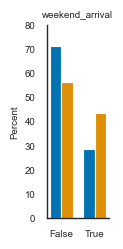

In [75]:
fig = plot_metric_comparison(
    df_real,
    df_synth,
    metric_col='weekend_arrival',
    figsize=(1.2, 2.5),
    lower_bound = 0,
    upper_bound = 80,
    yticks_step = 10,
    show_legend = False
)
plt.show()
if SAVE_FIGS:
    fig.savefig(f"{OUTPUT_DIR_FIG}/weekend_arrival.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.close(fig)

## night_arrival

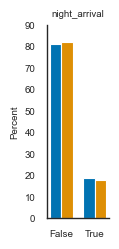

In [79]:
fig = plot_metric_comparison(
    df_real,
    df_synth,
    metric_col='night_arrival',
    figsize=(1.2, 2.5),
    lower_bound = 0,
    upper_bound = 90,
    yticks_step = 10,
    show_legend = False,
    horizontal= False
)
plt.show()
if SAVE_FIGS:
    fig.savefig(f"{OUTPUT_DIR_FIG}/night_arrival.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.close(fig)

## consciousness_level

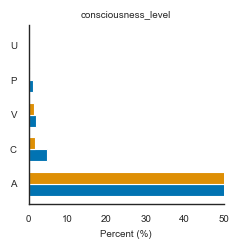

In [81]:
fig = plot_metric_comparison(
    df_real,
    df_synth,
    metric_col='consciousness_level',
    figsize=(2.4, 2.5),
    lower_bound = 0,
    upper_bound = 50,
    yticks_step = 10,
    horizontal= True,
    # label_rotation = 45,
    show_legend = False
)
plt.show()
if SAVE_FIGS:
    fig.savefig(f"{OUTPUT_DIR_FIG}/consciousness_level.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.close(fig)

## icd_block

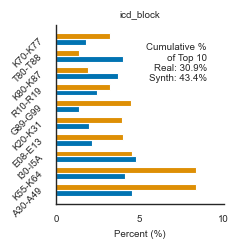

In [107]:
fig = plot_metric_comparison(
    df_real,
    df_synth,
    metric_col='icd_block',
    figsize=(2.4, 2.5),
    lower_bound = 0,
    upper_bound = 10,
    yticks_step = 5,
    horizontal= True,
    label_rotation = 45,
    top_k = 10,
    show_legend = False
)
plt.show()
if SAVE_FIGS:
    fig.savefig(f"{OUTPUT_DIR_FIG}/icd_block.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.close(fig)

## chief_complaint

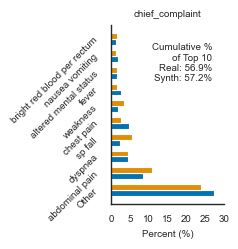

In [109]:
fig = plot_metric_comparison(
    df_real,
    df_synth,
    metric_col='chief_complaint',
    figsize=(2.4, 2.5),
    lower_bound = 0,
    upper_bound = 30,
    yticks_step = 5,
    top_k=10,
    label_rotation=45,
    horizontal=True,
    show_legend=False
)
plt.show()
if SAVE_FIGS:
    fig.savefig(f"{OUTPUT_DIR_FIG}/chief_complaint.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.close(fig)